PROJECT: Task 2: Toxic Span Detection (Sequence Labeling)

Name: Sai Chaitanya Pachipulusu
Stevens ID: 20011257

### Import libraries:

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import nltk
from typing import List, Tuple, Union
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import json
import random
import torch
import pickle
from sklearn.model_selection import train_test_split
from torch.nn import Module, ReLU, Linear, Sigmoid, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, TFBertModel
import spacy

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data loading:

In [ ]:
train_data = pd.read_csv('tsd_train.csv')
test_data = pd.read_csv('tsd_test.csv')

In [ ]:
print("Shape od Training Data: ", train_data.shape)
print(train_data.head())

Shape od Training Data:  (7939, 2)
                                               spans  \
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                       [33, 34, 35, 36, 37, 38, 39]   
2                                       [0, 1, 2, 3]   
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                       [32, 33, 34, 35, 36, 37, 38]   

                                                text  
0  Another violent and aggressive immigrant killi...  
1  I am 56 years old, I am not your fucking junio...  
2                  Damn, a whole family. Sad indeed.  
3  What a knucklehead. How can anyone not know th...  
4  "who do you think should do the killing?"\n\nA...  


In [ ]:
print("Shape of Testing Data: ", test_data.shape)
print(test_data.head())

Shape of Testing Data:  (2000, 2)
                                               spans  \
0  [84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...   
1                           [81, 82, 83, 84, 85, 86]   
2                                                 []   
3                                                 []   
4                                                 []   

                                                text  
0  That's right. They are not normal. And I am st...  
1  "Watch people die from taking away their healt...  
2  tens years ago i contacted the PDR and suggest...  
3  The parallels between the ANC and the Sicilian...  
4  Intel Community: ‘How can we work for a Presid...  


Data Cleaning:

- Data is clean. It does not have any null values/empty values.

In [ ]:
print(train_data.isnull().sum(axis=0))
print(test_data.isnull().sum(axis=0))

spans    0
text     0
dtype: int64
spans    0
text     0
dtype: int64


Data Pre-processing

- Converting the spans columns from string to valid lists.

In [ ]:
train_data["spans"] = [ast.literal_eval(x) for x in train_data["spans"]]
test_data["spans"] = [ast.literal_eval(x) for x in test_data["spans"]]

In [ ]:
empty_spans_train, empty_spans_test = 0, 0
for i in train_data["spans"]:
  if len(i) == 0:
    empty_spans_train += 1
print("Number of empty spans in train: ", empty_spans_train)

for i in test_data["spans"]:
  if len(i) == 0:
    empty_spans_test += 1
print("Number of empty spans in test: ", empty_spans_test)


Number of empty spans in train:  485
Number of empty spans in test:  394


In [ ]:
def new_spans(data_text, data_span):
    spans_new = []
    for idx in range(len(data_text)):
      sentence = []
      start = None
      for idx_arr in range(len(data_span[idx])):
        if start is None or data_span[idx][idx_arr] != data_span[idx][idx_arr-1] + 1:
          if start is not None:
            sentence.append(data_text[idx][start:data_span[idx][idx_arr-1]+1])
          start = data_span[idx][idx_arr]
      if start is not None:
        sentence.append(data_text[idx][start:data_span[idx][-1]+1])
      spans_new.append(sentence)
    return spans_new

In [ ]:
train_spans_new = new_spans(train_data["text"], train_data["spans"])
test_spans_new = new_spans(test_data["text"], test_data["spans"])

In [ ]:
nlp = spacy.blank("en")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def text_2_tokens(text):
  text = nlp(text)
  text_tokens = []
  for token in text:
      text_subtokens = tokenizer.tokenize(token.text)
      text_tokens += text_subtokens
  return text_tokens

In [ ]:
train_text_tokens, test_text_tokens = [], []
for idx in range(len(train_data)):
  train_text_token = text_2_tokens(train_data["text"][idx])
  train_text_tokens.append(train_text_token)

for idx in range(len(test_data)):
  test_text_token = text_2_tokens(test_data["text"][idx])
  test_text_tokens.append(test_text_token)

In [ ]:
def bin_tokens(tokens, text, spans):
  token_idx = []
  start, end = 0, 0
  for token in tokens:
    sent = text.lower()
    token = token.strip('#')
    start = sent.find(token, start)
    end = start + len(token)
    token_idx.append((start,end))
    start = end

  toxic_words = []
  for word, (start,end) in zip(tokens, token_idx):
    k = [i for i in range(start,end)]
    if any(i in spans for i in k):
      toxic_words.append(1)
    else:
      toxic_words.append(0)

  return toxic_words

In [ ]:
toxic_binary_train = []
for idx in range(len(train_data)):
  toxic_words = bin_tokens(train_text_tokens[idx], train_data["text"][idx], train_data["spans"][idx])
  toxic_binary_train.append(toxic_words)

In [ ]:
maxlen = max([len(x) for x in train_text_tokens])
print(maxlen)

336


In [ ]:
np.random.seed(70)
torch.manual_seed(70)

In [ ]:
train_tokens1 = [['[CLS]'] + t[:maxlen - 2] + ['[SEP]'] for t in train_text_tokens]
test_tokens = [['[CLS]'] + t[:maxlen - 2] + ['[SEP]'] for t in test_text_tokens]

print(len(train_tokens1), len(test_tokens))
print("Train tokens:", train_tokens1[0:2])
print("Test tokens:", test_tokens[0:2])

7939 2000
Train tokens: [['[CLS]', 'another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'us', 'citizen', '.', '.', '.', '.', 'sarcasm', '[SEP]'], ['[CLS]', 'i', 'am', '56', 'years', 'old', ',', 'i', 'am', 'not', 'your', 'fucking', 'junior', 'pal', '.', 'what', 'you', 'are', 'saying', 'makes', 'no', 'sense', '.', 'i', 'do', 'n', "'", 't', 'know', 'what', 'you', 'are', 'basin', '##g', 'this', 'on', '.', 'the', 'cheap', 'black', 'market', 'crap', 'is', 'still', 'coming', 'up', 'from', 'mexican', 'nationals', ',', 'and', 'the', 'good', 'stuff', 'from', 'bc', 'and', 'hum', '##bolt', '.', 'the', 'i', '##5', 'corridor', 'is', 'still', 'just', 'as', 'busy', ',', 'and', 'they', 'are', 'still', 'making', 'a', 'ton', 'of', 'money', '.', 'nothing', 'has', 'really', 'changed', 'except', 'that', 'the', 'legal', 'market', 'has', 'made', 'it', 'easy', 'for', 'anyone', 'of', 'legal', 'age', 'to', 'buy', 'it', '.', 'and', 'the', 'legal', 'market', 'is

In [ ]:
def pad_tokens(tokens, max_len=maxlen):
    length = len(tokens)
    pad_length = max_len - length
    if pad_length < 0:
        pad_length = 0
    
    tokens += [0] * pad_length                                 # pad tokens with zeros if necessary
    
    if length > max_len:                                       # truncate tokens if necessary
        tokens = tokens[:max_len]
    
    mask = [1] * length + [0] * pad_length                     # create attention mask to indicate which tokens are padding (0) and which are not (1)

    tokens = np.array(tokens, dtype="int")
    mask = np.array(mask, dtype="int")
    
    return tokens, mask

In [ ]:
def token_ids_and_masks(text_tokens):
    token_ids, masks = [], []

    for token in text_tokens:
        tokens, mask = pad_tokens(tokenizer.convert_tokens_to_ids(token), maxlen)
        token_ids.append(tokens)
        masks.append(mask)

    return np.array(token_ids), np.array(masks)

tr_token_ids, tr_masks = token_ids_and_masks(train_tokens1)
te_token_ids, te_masks = token_ids_and_masks(test_tokens)

In [ ]:
train_text_labels = [[0] + arr[:maxlen - 2] + [0] for arr in toxic_binary_train]

train_labels1 = []
for label in train_text_labels:

    if len(label) >= maxlen:                            # Truncate or pad the label to the desired length
        label = label[:maxlen]
    else:
        label += [0] * (maxlen - len(label))

    label = [value for value in label]                  # Convert to a array
    train_labels1.append(label)


In [ ]:
# Training and Validation
# dataframe - spans, text, toxic_phrases_train, train_text_tokens -> train_tokens -> (tr_token_ids, tr_masks), toxic_binary_train -> train_text_labels -> train_labels1, train_tokens -> train_split_tokens
# spans, text, toxic_phrases_train, tr_token_ids, tr_masks, train_labels, train_split_tokens   =====> train and valid

#Testing
# dataframe - spans, text, test_text_tokens -> test_tokens -> (te_token_ids, te_masks), toxic_binary_test -> test_text_labels -> test_labels
# spans, text, te_token_ids, te_masks, test_labels

In [ ]:
valid_ratio = 0.15

train_spans, valid_spans, train_text, valid_text, train_token_ids, valid_token_ids, train_masks, valid_masks, train_labels, valid_labels , train_tokens, valid_tokens \
= train_test_split(train_data["spans"].tolist(), train_data["text"].tolist(), tr_token_ids, tr_masks, train_labels1, train_tokens1, test_size=valid_ratio, random_state=42)

In [ ]:
class BertClassifier(Module):
  
    def __init__(self, hidden_units):
        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.hidden_layer = Linear(BertModel.from_pretrained('bert-base-uncased').config.hidden_size, hidden_units)
        self.activation = ReLU()
        self.out = Linear(hidden_units, 1)
        self.final_activation = Sigmoid()

    def forward(self, input, mask, labels=None):
        outputs = self.bert(input_ids=input, attention_mask=mask)          # Inputs are passed to bert model
        hid_layer_output = self.hidden_layer(outputs.last_hidden_state)    # Outputs of the last hidden state are the inputs to the next hidden state
        activation_output = self.activation(hid_layer_output)              # Those outputs are send through activation layer (ReLU)
        output_layer = self.out(activation_output)                         # Output from the Linear layer
        final_output = self.final_activation(output_layer)                 # This is paased through final activation function (sigmoid)

        bce_loss = BCELoss()
        loss = 0
        if labels is not None:
            loss = bce_loss(final_output, labels.float())
            
        return loss, final_output

hidden_units = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(hidden_units).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transfo

In [ ]:
# from torchsummary import summary
# import torchvision.models as models
# summary(model, input_size, batch_size=-1, device='cuda')

In [ ]:
import sys

with open('network.txt', 'w') as f:
    sys.stdout = f
    summary(model, input_size, device=device.type)
    sys.stdout = sys.__stdout__

In [ ]:
from torchsummary import summary
# Generate the summary and save it to "network.txt"
input_size = (1, 512)  # Adjust the input size according to your model input
with open("network.txt", "w") as f:
    summary(model, input_size, device=device.type, file=f)


In [ ]:
# from torchsummary import summary

# with open("network.txt", "w") as f:
#     summary(model, (6748, 336,)) # Replace input_size with the size of your input
#     f.write(str(summary))

In [ ]:
# (torch.tensor(train_token_ids)).size()
# (torch.tensor(train_masks)).size()
# train_dataset.shape

In [ ]:
print(model)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
BATCH_SIZE = 8

train_dataset = TensorDataset(
    torch.tensor(train_token_ids),
    torch.tensor(train_masks),
    torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = TensorDataset(
    torch.tensor(valid_token_ids),
    torch.tensor(valid_masks),
    torch.tensor(valid_labels))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(torch.tensor(te_token_ids), torch.tensor(te_masks))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-6)

In [ ]:
EPOCHS = 3
loss = BCELoss()
total_len = len(train_token_ids)
valid_len = len(valid_token_ids)
epoch_train_loss = []
epoch_valid_loss = []
for epoch_num in range(EPOCHS):
    train_losses = []
    valid_losses = []
    model.train()
    for step, batch_data in enumerate(tqdm(train_dataloader)):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        labels = labels.unsqueeze(-1)                                            # make labels shape similar to output shape before passing to loss. labels- (batch_size x sequence length x 1)

        loss, _ = model(token_ids, masks, labels)                                # token_ids, masks, labels = all are of size (batch_size x sequence length)

        train_loss = loss.item()
        
        model.zero_grad()
        loss.backward()

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_losses.append(train_loss)

    epoch_train_loss.append(np.mean(train_losses))

    model.eval()                                                                 # switch the model to evaluation mode
    with torch.no_grad():                                                        # temporarily disable gradient calculations within the for loop
        for step1, batch_data1 in enumerate(tqdm(valid_dataloader)):
            token_ids1, masks1, labels1 = tuple(t.to(device) for t in batch_data1)
            labels1 = labels1.unsqueeze(-1)  
            valid_loss, _ = model(token_ids1, masks1, labels1)
            valid_losses.append(valid_loss.item())

    epoch_valid_loss.append(np.mean(valid_losses))

    print(f'\nEpoch {epoch_num + 1} / {EPOCHS} - train loss: {epoch_train_loss[-1] :.4f} - valid loss: {epoch_valid_loss[-1] :.4f}')

100%|██████████| 149/149 [00:26<00:00,  5.71it/s]



Epoch 1 / 3 - train loss: 0.0758 - valid loss: 0.0368


100%|██████████| 149/149 [00:26<00:00,  5.72it/s]



Epoch 2 / 3 - train loss: 0.0358 - valid loss: 0.0333


100%|██████████| 149/149 [00:26<00:00,  5.71it/s]


Epoch 3 / 3 - train loss: 0.0323 - valid loss: 0.0319


In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

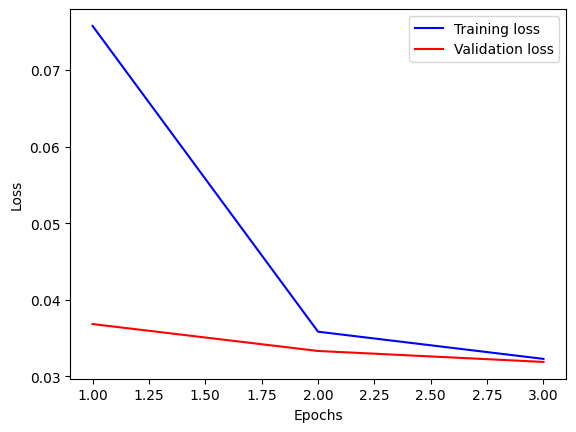

In [ ]:
EPOCHS1 = [1,2,3]
plt.plot(EPOCHS1, epoch_train_loss, 'b', label = 'Training loss')
plt.plot(EPOCHS1, epoch_valid_loss, 'r', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'NLP_project_checkpoint.pt')

In [ ]:
# from google.colab import files
# files.download('NLP_project_checkpoint.pt')

In [ ]:
model.eval()                                                               # switch the model to evaluation mode

valid_token_ids, valid_masks, valid_preds = [], [], []
                                                
with torch.no_grad():                                                      # temporarily disable gradient calculations within the for loop
    for step3, batch_data3 in enumerate(tqdm(valid_dataloader)):
        valid_tokens_batch, valid_masks_batch, valid_labels_batch = tuple(t.to(device) for t in batch_data3)
        valid_labels_batch = valid_labels_batch.unsqueeze(-1)
        _, valid_output = model(valid_tokens_batch, valid_masks_batch, valid_labels_batch)
        valid_token_ids.append(valid_tokens_batch)
        valid_masks.append(valid_masks_batch)
        valid_preds.append(valid_output[:, :, 0])

valid_token_ids = torch.cat(valid_token_ids, dim=0).tolist()
valid_masks = torch.cat(valid_masks, dim=0).tolist()
valid_preds = torch.cat(valid_preds, dim=0).tolist()

100%|██████████| 149/149 [00:25<00:00,  5.76it/s]


In [ ]:
model.eval()                                                         # switch the model to evaluation mode

test_tokens_ids, test_masks, test_preds = [], [], []

with torch.no_grad():                                                # temporarily disable gradient calculations within the for loop
    for step, batch_data in enumerate(tqdm(test_dataloader)):
        token_ids, masks = tuple(t.to(device) for t in batch_data)
        _, output = model(token_ids, masks)
        test_tokens_ids += token_ids.tolist()
        test_masks += masks.tolist()
        test_preds += output[:, :, 0].tolist()

100%|██████████| 250/250 [00:44<00:00,  5.56it/s]


In [ ]:
import copy
def threshold_fun(preds, threshold):
    # testy_preds = []
    # for i in test_preds:
    #     testy_preds.append(np.mean(i))         # converting the predicted values into binary values given a threshold
    pred = copy.deepcopy(preds)
    for i in range(len(pred)):
        for j in range(len(pred[0])):
          if pred[i][j] >= threshold:
              pred[i][j] = 1
          else:
              pred[i][j] = 0
    return pred

In [ ]:
valid_pred = threshold_fun(valid_preds, 0.6)

In [ ]:
def truncated(preds, masks): 
  new_preds = []
  for pr, ma in zip(preds, masks):
    pr = [pr[i] for i in range(len(pr)) if ma[i]==1]   #truncate
    new_preds.append(pr)
  return new_preds

In [ ]:
valid_new_labels = truncated(valid_labels, valid_masks)
valid_new_preds = truncated(valid_pred, valid_masks)

In [ ]:
def id_2_tokens(token_ids):
    id2token=[]
    for i in range(len(token_ids)):
        id2token.append(tokenizer.convert_ids_to_tokens(token_ids[i]))
    return id2token

In [ ]:
valid_tokens_new = id_2_tokens(valid_token_ids)

In [ ]:
def toxic_tokens(tokens, predicts, texts):
    final_toxic_tokens = []
    for (token, pred, text) in zip(tokens, predicts, texts):
        toxic_tokens_spans = []
        start = 0
        for i in range(len(token)):
            tk = token[i].strip('#')
            start = text.find(tk,start)
            end = start + len(tk)
            if pred[i] == 1 and start!=-1:
                toxic_tokens_spans.extend(range(start,end))
            start=end
        final_toxic_tokens.append(toxic_tokens_spans)
    return final_toxic_tokens

In [ ]:
valid_toxic_tokens = toxic_tokens(valid_tokens, valid_new_preds, valid_text)

In [ ]:
def f1_score(ground_truth, prediction):
    
    #Calculates F1 score for a set of spans
    true_positives = 0
    if len(ground_truth) == 0 and len(prediction) == 0:
        return 1.0
    elif len(ground_truth) == 0 and len(prediction) != 0:
        return 0.0
    elif len(ground_truth) != 0 and len(prediction) == 0:
        return 0.0
    else:
        true_positives_set = set(ground_truth).intersection(set(prediction))
        true_positives_len = len(true_positives_set)

        pred_cardinal = len(prediction)
        grou_cardinal = len(ground_truth)
        precision = true_positives_len / pred_cardinal
        recall = true_positives_len / grou_cardinal
        if precision + recall == 0:
            return 0.0
        else:
            f1_score = 2 * precision * recall / (precision + recall)
            return f1_score

In [ ]:
f1_score_valid = []
for i in range(len(valid_toxic_tokens)):
    f1_score_valid.append(f1_score(valid_spans[i], valid_toxic_tokens[i]))
print(np.mean(f1_score_valid))

0.5929392703873725
